# Training U-Net with logging Example Notebook

This notebook demonstrates how to train `virtual_stain_flow.models` module,
demoing with trainer and logging. 

## Dependencies

In [ ]:
import json
import pathlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchmetrics.image import MultiScaleStructuralSimilarityIndexMeasure
from mlflow.tracking import MlflowClient

from virtual_stain_flow.trainers.logging_trainer import SingleGeneratorTrainer
from virtual_stain_flow.vsf_logging.MlflowLogger import MlflowLogger
from virtual_stain_flow.vsf_logging.callbacks.PlotCallback import PlotPredictionCallback
from virtual_stain_flow.models.unet import UNet

## Retrieve Demo Data

In [2]:
data_dir = pathlib.Path(
    "/mnt/data_nvme1/data/alsf_portable/12000_train_set"
).resolve(strict=True)

if not data_dir.exists():
    raise FileNotFoundError(f"Data directory {data_dir} does not exist.")

dataset_index_json = data_dir / "dataset.json"

# dataset_index_json = list(data_dir.rglob("dataset.json"))
if not dataset_index_json:
    raise FileNotFoundError(f"No dataset.json found in {data_dir}.")
# dataset_index_json = dataset_index_json[0]

with open(dataset_index_json, "r") as f:
    dataset_index = json.load(f)

index = pd.DataFrame(dataset_index['file_index']['records'])
print(f"Total number of samples: {len(index)}")
index = index.sample(n=40, random_state=42).reset_index(drop=True)
print(f"Subset number of samples: {len(index)}")
print(index.head())

Total number of samples: 80
Subset number of samples: 40
                           OrigBrightfield  \
0  r14c21f02p01-ch1sk1fk1fl1_9a6869ec.tiff   
1           r13c21f01p01-ch1sk1fk1fl1.tiff   
2           r14c22f08p01-ch1sk1fk1fl1.tiff   
3  r14c22f02p01-ch1sk1fk1fl1_46c64d1d.tiff   
4           r14c21f07p01-ch1sk1fk1fl1.tiff   

                                   OrigAGP  \
0  r14c21f02p01-ch3sk1fk1fl1_88aedd7d.tiff   
1           r13c21f01p01-ch3sk1fk1fl1.tiff   
2           r14c22f08p01-ch3sk1fk1fl1.tiff   
3  r14c22f02p01-ch3sk1fk1fl1_17b55695.tiff   
4           r14c21f07p01-ch3sk1fk1fl1.tiff   

                                   OrigDNA  \
0  r14c21f02p01-ch5sk1fk1fl1_abe84992.tiff   
1           r13c21f01p01-ch5sk1fk1fl1.tiff   
2           r14c22f08p01-ch5sk1fk1fl1.tiff   
3  r14c22f02p01-ch5sk1fk1fl1_27fd7230.tiff   
4           r14c21f07p01-ch5sk1fk1fl1.tiff   

                                    OrigER  \
0  r14c21f02p01-ch2sk1fk1fl1_44eb9c0e.tiff   
1           r13c21f0

## Define custom dataset that simply crops the center patch and does normalization

In [3]:
class SimpleDataset(Dataset):
    def __init__(self, index_df, data_dir):
        self.index_df = index_df
        self.data_dir = data_dir
    
    def __len__(self):
        return len(self.index_df)
    
    def __getitem__(self, idx):
        row = self.index_df.iloc[idx]
        
        # Load images
        brightfield_path = self.data_dir / 'data' / row['OrigBrightfield']
        dna_path = self.data_dir / 'data' / row['OrigDNA']
        
        brightfield_img = Image.open(brightfield_path)
        brightfield_img.convert('I;16')
        dna_img = Image.open(dna_path)
        dna_img.convert('I;16')
        brightfield_img = np.asarray(brightfield_img, dtype=np.float32)
        dna_img = np.asarray(dna_img, dtype=np.float32)

        # Get image dimensions
        width, height = brightfield_img.shape
        
        # Calculate crop coordinates for center 256x256
        left = (width - 256) // 2
        top = (height - 256) // 2
        right = left + 256
        bottom = top + 256
        
        # Crop center 256x256
        brightfield_crop = brightfield_img[top:bottom,left:right]
        dna_crop = dna_img[top:bottom,left:right]

        # Normalize by 16bit max value
        factor = 2 ** 16 - 1
        brightfield_crop = brightfield_crop / factor
        dna_crop = dna_crop / factor

        # Convert to tensor
        brightfield_tensor = torch.from_numpy(brightfield_crop).unsqueeze(0)  # Add channel dimension
        dna_tensor = torch.from_numpy(dna_crop).unsqueeze(0)  # Add channel dimension

        return brightfield_tensor, dna_tensor

# Create dataset instance
dataset = SimpleDataset(index, data_dir)
print(f"Dataset created with {len(dataset)} samples")

Dataset created with 40 samples


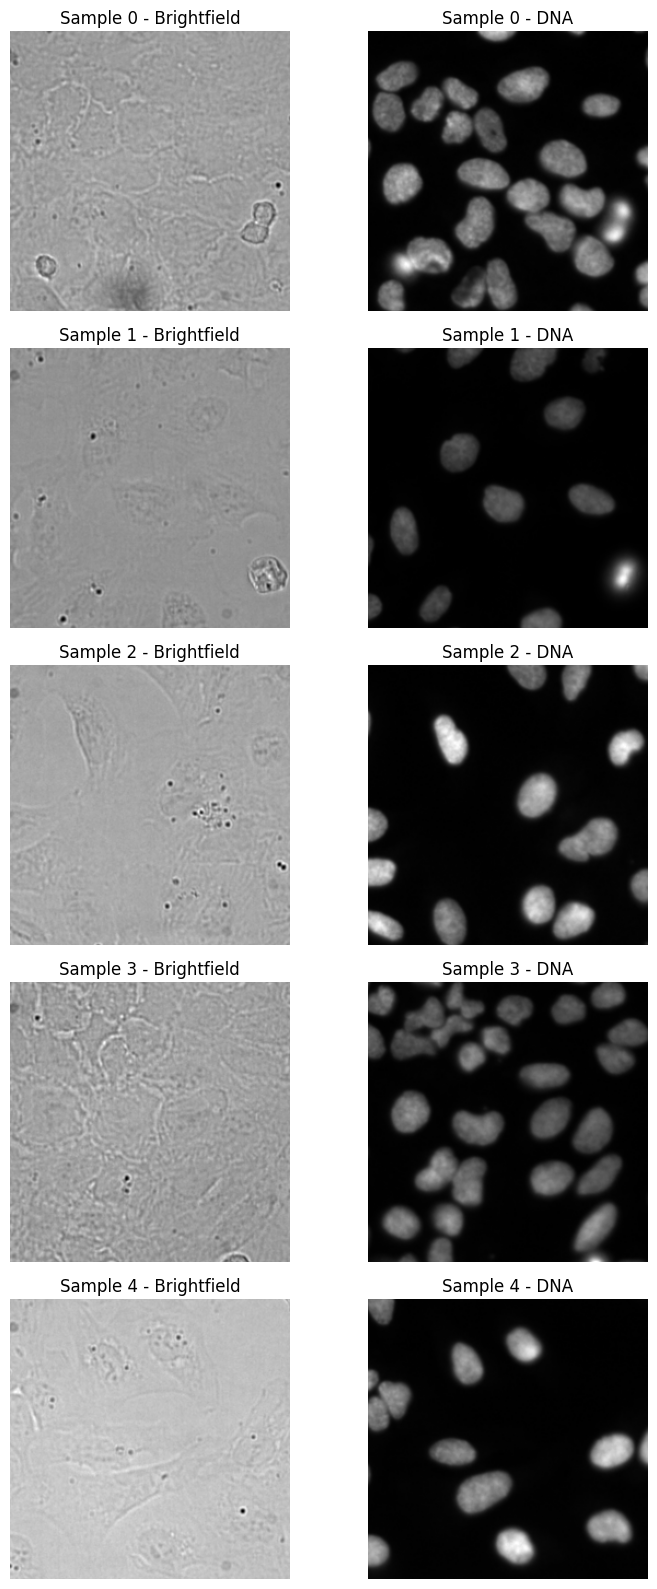

In [4]:
# Plot the first 5 samples from the dataset
fig, axes = plt.subplots(5, 2, figsize=(8, 16))

for i in range(5):
    brightfield, dna = dataset[i]
    brightfield = brightfield.numpy().squeeze()
    dna = dna.numpy().squeeze()

    # Plot brightfield image
    axes[i, 0].imshow(brightfield.squeeze(), cmap='gray')
    axes[i, 0].set_title(f'Sample {i} - Brightfield')
    axes[i, 0].axis('off')
    
    # Plot DNA image
    axes[i, 1].imshow(dna.squeeze(), cmap='gray')
    axes[i, 1].set_title(f'Sample {i} - DNA')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

## Configure and train

In [ ]:
# Hyperparameters
batch_size = 16
epochs = 100
learning_rate = 0.001 # larger learning rate for demo purposes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Batch with DataLoader
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Model & Optimizer
fully_conv_unet = UNet(
    in_channels=1,
    out_channels=1,
    depth=4,
    encoder_down_block='conv',
    decoder_up_block='convt',
    act_type='sigmoid'
)
optimizer = torch.optim.Adam(fully_conv_unet.parameters(), lr=learning_rate)

# Plotting callback to visualize predictions during training
plot_callback = PlotPredictionCallback(
    name="plot_callback_with_train_data",
    dataset=dataset,
    indices=[0,1,2,3,4], # first 5 samples
    plot_metrics=[torch.nn.L1Loss()],
    every_n_epochs=5,
    show_plot=False
)

# MLflow Logger
logger = MlflowLogger(
    name="logger",
    experiment_name="vsf_examples",
    tracking_uri="http://127.0.0.1:5000",
    run_name="experiment_training_with_plots",
    description="Training a UNet model on a simple dataset for demo purposes",
    callbacks=[plot_callback],
    save_model_at_train_end=True,
    save_model_every_n_epochs=1,
    save_best_model=True
)

# Initialize Trainer and start training
trainer = SingleGeneratorTrainer(
    model=fully_conv_unet,
    optimizer=optimizer,
    losses=[
        torch.nn.L1Loss(),
        MultiScaleStructuralSimilarityIndexMeasure(
            data_range=1.0,
            kernel_size=11,
            sigma=1.5,
        )
    ],
    loss_weights=[1.0, -1.0], # minimize L1 distance and maximize MS-SSIM
    device=device,
    train_loader=train_loader,
    val_loader=None,
    test_loader=None,
)

trainer.train(logger=logger, epochs=epochs)

MLflow run started with ID: a71d48b54d0540dda7d985eb130abfc9


Training: 100%|██████████| 100/100 [05:00<00:00,  3.01s/epoch, Train Batch 3/3]


🏃 View run experiment_training_with_plots at: http://127.0.0.1:5000/#/experiments/2/runs/a71d48b54d0540dda7d985eb130abfc9
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


## Visualize training outcome through MLflow client

### Display the last logged prediction plot artifact

Run ID: a71d48b54d0540dda7d985eb130abfc9
Run Name: experiment_training_with_plots
Last epoch plot: plots/epoch/plot_predictions/epoch_99.png


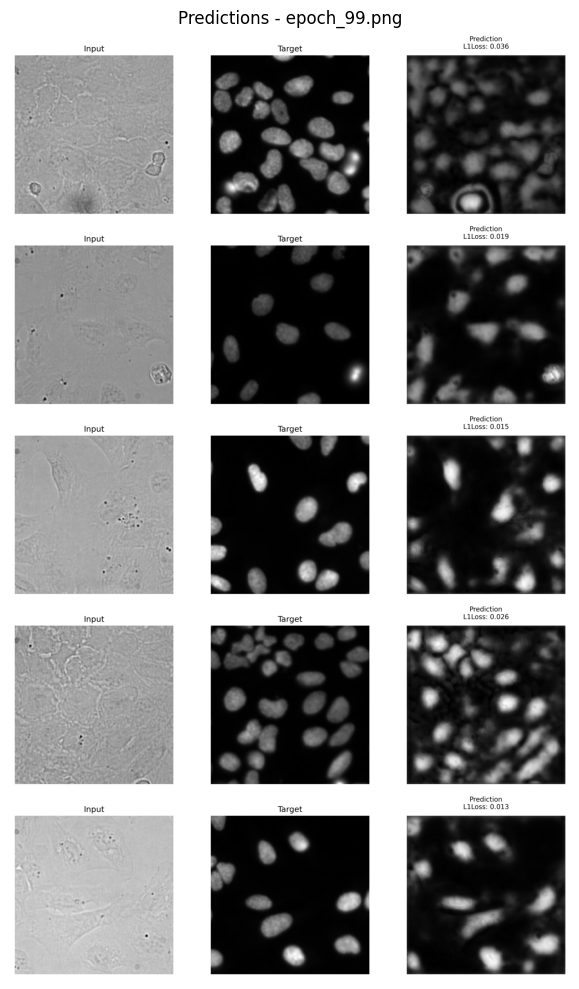

In [ ]:
# Create MLflow client
client = MlflowClient(tracking_uri="http://127.0.0.1:5000")

# Get the experiment by name
experiment = client.get_experiment_by_name("vsf_examples")

if experiment is None:
    print("Experiment 'vsf_examples' not found")
else:
    # Search for runs with the specific run name
    runs = client.search_runs(
        experiment_ids=[experiment.experiment_id],
        filter_string="tags.mlflow.runName = 'experiment_training_with_plots'"
    )
    
    if len(runs) == 0:
        print("No runs found with name 'experiment_training_with_plots'")
    else:
        # Get the most recent run (first in list)
        run = runs[0]
        print(f"Run ID: {run.info.run_id}")
        print(f"Run Name: {run.data.tags.get('mlflow.runName')}")

        plot_artifacts = client.list_artifacts(run.info.run_id, path='plots/epoch/plot_predictions/')

        # Filter for PNG files and sort by path (which includes epoch number)
        png_files = [artifact for artifact in plot_artifacts if artifact.path.endswith('.png')]

        # Get full paths and sort by epoch number
        png_files_sorted = sorted(png_files, key=lambda x: int(x.path.split('_')[-1].split('.')[0]))
        most_recent_png = png_files_sorted[-1]

        print(f"Last epoch plot: {most_recent_png.path}")

        # Download and display the image
        local_path = client.download_artifacts(run.info.run_id, most_recent_png.path)
        img = Image.open(local_path)
        plt.figure(figsize=(12, 10))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Predictions - {most_recent_png.path.split('/')[-1]}")
        plt.tight_layout()
        plt.show()

### Also visualize metrics from tracking

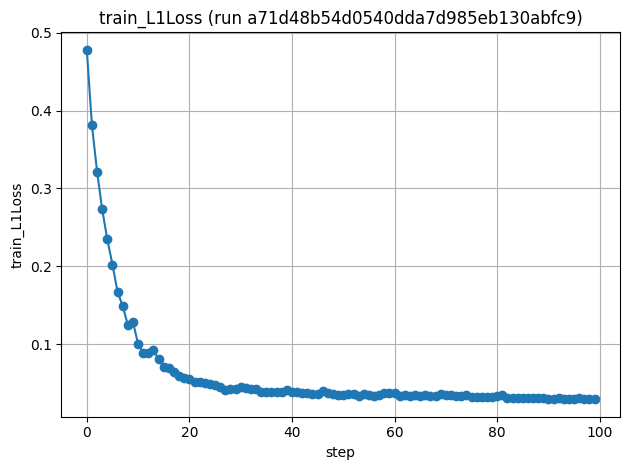

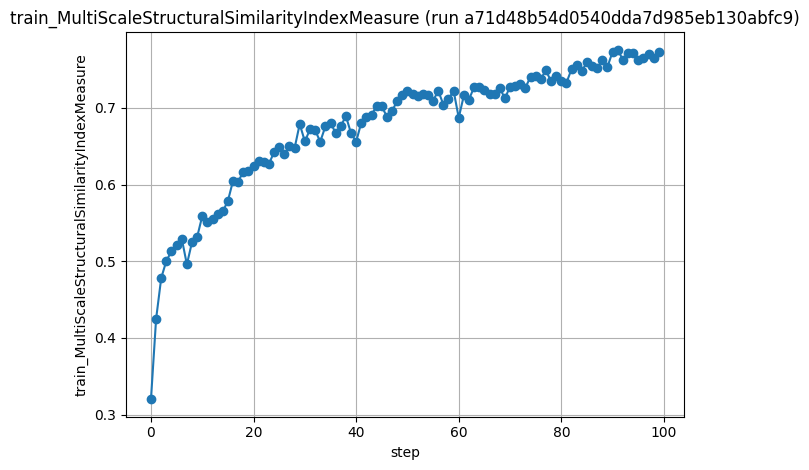

In [7]:
metric_keys = list(run.data.metrics.keys()) or []

for metric_name in metric_keys:
    # 2. Get full history for each metric (all steps)
    history = client.get_metric_history(run.info.run_id, metric_name)
    if not history:
        continue

    steps = [m.step for m in history]
    values = [m.value for m in history]

    # 3. Plot each metric vs step
    plt.figure()
    plt.plot(steps, values, marker="o")
    plt.title(f"{metric_name} (run {run.info.run_id})")
    plt.xlabel("step")
    plt.ylabel(metric_name)
    plt.grid(True)
    plt.tight_layout()